# 1. Loading Dataset

Using Kaggle CLI to download dataset. To run this notebook, create a legacy API key on Kaggle and upload the 'kaggle.json' file to Google Colab.

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download samuelcortinhas/muffin-vs-chihuahua-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification
License(s): CC0-1.0
 97% 458M/474M [00:01<00:00, 401MB/s]
100% 474M/474M [00:01<00:00, 442MB/s]


In [3]:
! unzip muffin-vs-chihuahua-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/muffin/img_2_671.jpg  
  inflating: test/muffin/img_2_681.jpg  
  inflating: test/muffin/img_2_689.jpg  
  inflating: test/muffin/img_2_709.jpg  
  inflating: test/muffin/img_2_721.jpg  
  inflating: test/muffin/img_2_73.jpg  
  inflating: test/muffin/img_2_735.jpg  
  inflating: test/muffin/img_2_752.jpg  
  inflating: test/muffin/img_2_757.jpg  
  inflating: test/muffin/img_2_762.jpg  
  inflating: test/muffin/img_2_767.jpg  
  inflating: test/muffin/img_2_78.jpg  
  inflating: test/muffin/img_2_784.jpg  
  inflating: test/muffin/img_2_799.jpg  
  inflating: test/muffin/img_2_8.jpg  
  inflating: test/muffin/img_2_810.jpg  
  inflating: test/muffin/img_2_819.jpg  
  inflating: test/muffin/img_2_82.jpg  
  inflating: test/muffin/img_2_821.jpg  
  inflating: test/muffin/img_2_824.jpg  
  inflating: test/muffin/img_2_827.jpg  
  inflating: test/muffin/img_2_838.jpg  
  inflating: test/muffin/img_2_857.jpg  
  inflating

Setting up DataLoaders

In [4]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

trainset = datasets.ImageFolder('train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder('test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('chihuahua', 'muffin')

Visualizing images

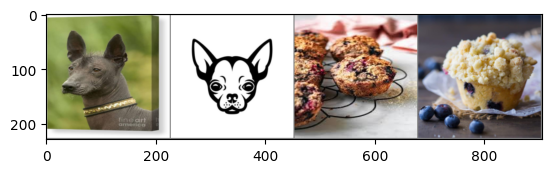

chihuahua chihuahua muffin muffin


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# 2. Defining CNN

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # first convolution
        self.conv1 = nn.Conv2d(3, 32, stride=2, kernel_size=3, padding=1)
        # batch norm 1
        self.bn1 = nn.BatchNorm2d(32)
        # second convolution
        self.conv2 = nn.Conv2d(32, 64, stride=2, kernel_size=3, padding=1)
        # batch norm 2
        self.bn2 = nn.BatchNorm2d(64)
        # third convolution
        self.conv3 = nn.Conv2d(64, 128, stride=2, kernel_size=3, padding=1)
        # batch norm 3
        self.bn3 = nn.BatchNorm2d(128)
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # define your FC layer(s)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, len(classes))

    def forward(self, x):
        # successive convolutions, BN, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # FC layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [8]:
import torch.optim as optim

# define loss for multi-class classification
criterion = nn.CrossEntropyLoss()
# define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training the CNN model

In [10]:
num_epochs = 10
# loop over the dataset multiple times
for epoch in range(num_epochs):
  for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 10 == 9:
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}')

print('Finished Training')

[1,    10] loss: 0.688
[1,    20] loss: 0.654
[1,    30] loss: 0.633
[1,    40] loss: 0.641
[1,    50] loss: 0.513
[1,    60] loss: 0.524
[1,    70] loss: 0.522
[1,    80] loss: 0.619
[1,    90] loss: 0.478
[1,   100] loss: 0.524
[1,   110] loss: 0.415
[1,   120] loss: 0.411
[1,   130] loss: 0.576
[1,   140] loss: 0.450
[2,    10] loss: 0.355
[2,    20] loss: 0.390
[2,    30] loss: 0.309
[2,    40] loss: 0.282
[2,    50] loss: 0.413
[2,    60] loss: 0.349
[2,    70] loss: 0.410
[2,    80] loss: 0.229
[2,    90] loss: 0.262
[2,   100] loss: 0.441
[2,   110] loss: 0.241
[2,   120] loss: 0.360
[2,   130] loss: 0.249
[2,   140] loss: 0.235
[3,    10] loss: 0.307
[3,    20] loss: 0.298
[3,    30] loss: 0.104
[3,    40] loss: 0.359
[3,    50] loss: 0.221
[3,    60] loss: 0.191
[3,    70] loss: 0.350
[3,    80] loss: 0.318
[3,    90] loss: 0.429
[3,   100] loss: 0.271
[3,   110] loss: 0.367
[3,   120] loss: 0.142
[3,   130] loss: 0.229
[3,   140] loss: 0.224
[4,    10] loss: 0.193
[4,    20] 

# 3. Evaluation

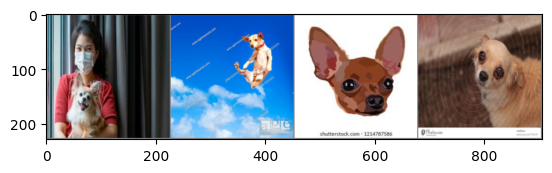

GroundTruth:  chihuahua chihuahua chihuahua chihuahua


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_display = images[:4]

# print images
imshow(torchvision.utils.make_grid(images_display))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  muffin muffin muffin chihuahua


Let's test our model on more images to get a better idea of our test accuracy.

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on {total} test images: {100 * correct // total} %')

Accuracy of the network on 1184 test images: 72 %


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if prediction == label:
              correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: chihuahua is 73.6 %
Accuracy for class: muffin is 70.2 %
